## Exemplo: Superfícies circular e elíptica com GD em mini-batch

Neste exemplo compararemos o comportamento do gradiente descendente em mini-batch em superfícíes com formatos circular e elíptico.

Usamos as **mesmas funções objetivo e hipótese** em ambos os casos, sendo a única **diferença o intervalo de variação** de um dos atributos.

In [338]:
# Import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math
import random

### Semente que será usada ao longo do exemplo.

In [339]:
seed = 0

### Definição de funções.

In [340]:
def errorSurface(x1, x2, y_noisy):
    # Retrieve the number of samples.
    N = len(y_noisy)
    # Generate values for parameters.
    M = 200
    a1 = np.linspace(-2.0, 10.0, M)
    a2 = np.linspace(-2.0, 10.0, M)

    A1, A2 = np.meshgrid(a1, a2)

    # Generate points for plotting the cost-function surface.
    J = np.zeros((M,M))
    for iter1 in range(0, M):
        for iter2 in range(0, M):
            # Hypothesis function.
            yhat = A1[iter1, iter2]*x1 + A2[iter1, iter2]*x2
            J[iter1, iter2] = (1.0/N)*np.sum(np.square(y_noisy - yhat))

    return A1, A2, J

def normalEquation(X, y_noisy):
    # Retrieve number of samples.
    N = len(y_noisy)

    # Closed-form solution.
    a_opt = np.linalg.pinv(np.transpose(X).dot(X)).dot(np.transpose(X).dot(y_noisy))

    # Hypothesis function.
    yhat = X.dot(a_opt)

    # Mean Squared Error.
    Joptimum = (1.0/N)*np.sum(np.power((y_noisy - yhat), 2))

    return Joptimum, a_opt

# learning schedule: Decaimento temporal
def timeBasedDecay(alpha_int, k, t):
    return alpha_int / (1 + k*t)

# learning schedule: Exponential Decay.
def exponentialDecay(alpha_int, k, t):
    return alpha_int * np.exp(-k*t)

def stepDecay(alpha_int, t, drop=0.5, epochs_drop = 4.0):
    alpha = alpha_int * math.pow(drop, math.floor((1+t)/epochs_drop))
    return alpha

def learning_schedule(typels, alpha_int, t, k=0.01, mu=0.9):
    if(typels=='exp'):
        mom = 0.0
        alpha = exponentialDecay(alpha_int, k, t)
    elif(typels=='time'):
        mom = 0.0
        alpha = timeBasedDecay(alpha_int, k, t)
    elif(typels=='step'):
        mom = 0.0
        alpha = stepDecay(alpha_int, t)
    elif(typels=='mom'):
        mom = mu
        alpha = alpha_int
    elif(typels=='momstep'):
        mom = mu
        alpha = stepDecay(alpha_int, t)
    else:
        mom = 0.0
        alpha = alpha_int
    return alpha, mom

def mbgd(X, y_noisy, n_epochs, typels, alpha_init, k=0.01, mu=0.9, mb_size=5):
    '''Mini-batch Gradient Descent implementation.'''

    # Number of examples.
    N = len(y_noisy)

    # Random initialization of parameters.
    a = np.array([-2.0, -2.0]).reshape(2, 1)

    # Create vector for parameter history.
    a_hist = np.zeros((2, n_epochs*(N//mb_size)+1))

    # Initialize history vector.
    a_hist[:, 0] = a.reshape(2,)

    # Create vector to store eta history.
    alpha_hist = np.zeros((n_epochs*(N//mb_size)))

    # Momentum term.
    v = np.zeros((2, 1))

    # Create array for storing error values.
    Jgd = np.zeros((n_epochs+1,))

    # Calculate initial MSE.
    Jgd[0] = (1.0/N)*np.sum(np.power(y_noisy - X.dot(a), 2))

    update_hist = np.zeros((2, n_epochs*(N//mb_size)))

    # Mini-batch gradient-descent loop.
    inc = 0
    for epoch in range(n_epochs):

        # Shuffle the whole dataset before every epoch.
        random_indexes = random.sample(range(0, N), N)

        # Update the weights with the mini-batches.
        for i in range(0, N//mb_size):
            # Randomly selecting one mini-batch for training.
            start = i*mb_size
            end = mb_size*(i+1)
            mb_indexes = random_indexes[start:end]
            Xi = X[mb_indexes]
            yi = y_noisy[mb_indexes]

            # Update the learning rate value.
            alpha, mu = learning_schedule(typels, alpha_init, inc, k, mu)

            # Estimate the gradient with just one sample.
            gradient = -(2.0/mb_size)*Xi.T.dot(yi - Xi.dot(a))

            # Update the weights with the momentum term.
            v = mu*v + (1 - mu)*gradient
            a = a - alpha*v

            # Update arrays with history values.
            a_hist[:, inc+1] = a.reshape(2,)
            update_hist[:, inc] = v.reshape(2,)
            alpha_hist[inc] = alpha

            # Iteration counter.
            inc += 1

        # Calculate the current MSE.
        Jgd[epoch] = (1.0/N)*np.sum(np.power((y_noisy - X.dot(a)), 2))

    return a, Jgd, a_hist, update_hist, alpha_hist, inc

### Superfície de erro circular.

O intervalo de variação dos atributos é similar.

In [341]:
# Always reset the pseudo random number generator to the same number.
np.random.seed(seed)
random.seed(seed)

In [342]:
# Define the number of examples.
N = 100

# Features.
x1 = np.random.randn(N, 1)
x2 = np.random.randn(N, 1)

# Noise.
w = np.random.randn(N, 1)

# Generate target function.
y = 4 * x1 + 4 * x2

# Observable model.
y_noisy = y + w

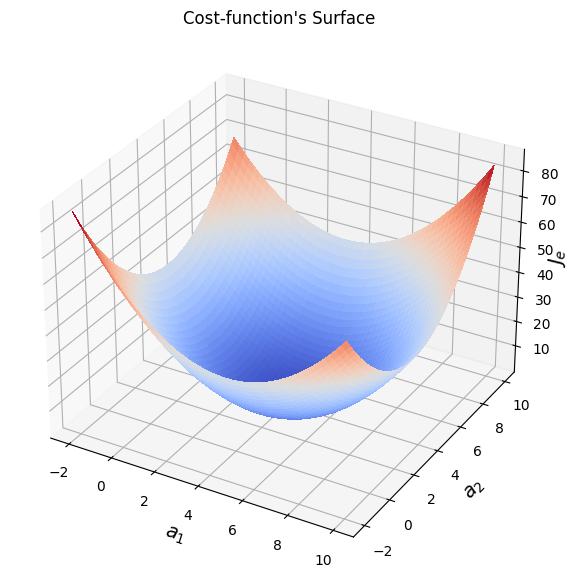

In [343]:
# Calculate the error surface.
A1, A2, J = errorSurface(x1, x2, y_noisy)

# Plot cost-function surface.
fig = plt.figure(figsize=(7,7))
plt.subplot(projection='3d')
ax = fig.gca()
surf = ax.plot_surface(A1, A2, J, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('$a_1$', fontsize=14)
ax.set_ylabel('$a_2$', fontsize=14)
ax.set_zlabel('$J_e$', fontsize=14)
ax.zaxis.labelpad=-4
plt.title('Cost-function\'s Surface')
#Show the plot.
plt.show()

### Encontrando a solução ótima.

In [344]:
# Concatenate both column vectors, x1 and x2.
X = np.c_[x1, x2]

# Calculate optimum weights.
Joptimum, a_opt = normalEquation(X, y_noisy)

# Print a1 and a2 weights.
print('peso a1:', a_opt[0, 0])
print('peso a2:', a_opt[1, 0])
# Print the optimum MSE.
print('Erro:', Joptimum)

peso a1: 4.063454839808389
peso a2: 4.039574578360912
Erro: 0.9034158375788076


### Econtrando a solução com GD em mini-batch.

In [345]:
# Number of epochs.
n_epochs = 50

# Learning rate.
alpha_mbgd = 0.4

# Mini batch size
mb_size = 5

# mini-batch GD.
a_mbgd, Jgd, a_hist, update_hist, alpha_hist, inc = mbgd(X, y_noisy, n_epochs, 'none', alpha_mbgd, 0.01, 0.0, mb_size)

# Print a1 and a2 weights.
print('peso a1:', a_mbgd[0, 0])
print('peso a2:', a_mbgd[1, 0])

peso a1: 3.9360738565456233
peso a2: 3.6952402997664304


### Superfície de contorno com histórico de atualização dos pesos.

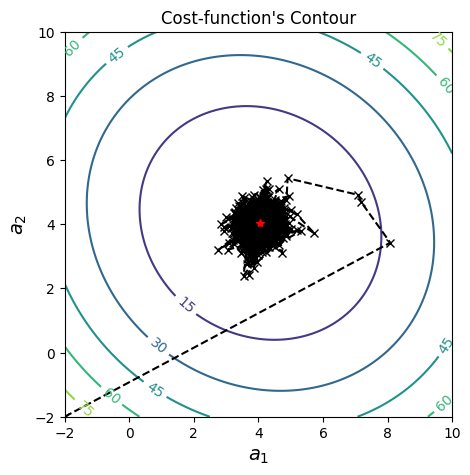

In [346]:
# Plot figure.
fig = plt.figure(figsize=(5,5))
cp = plt.contour(A1, A2, J)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s Contour')
plt.plot(a_hist[0, 0:inc+1], a_hist[1, 0:inc+1], 'kx--')
plt.plot(a_opt[0], a_opt[1], c='r', marker='*')
plt.xticks(np.arange(-2, 12, step=2.0))
plt.yticks(np.arange(-2, 12, step=2.0))
plt.show()

#### Observações

+ O vetor gradiente muda de direção algumas vezes (devido à aproximação estocástica e aos dados serem ruidosos), mas o algoritmo se aproxima da região do mínimo rapidamente.


+ Por a superfície ser circular, o algoritmo não oscila de um lado para o outro da superfície, indo em direção à região com o ponto de mínimo rapidamente.

### Variação dos vetores gradiente e update.

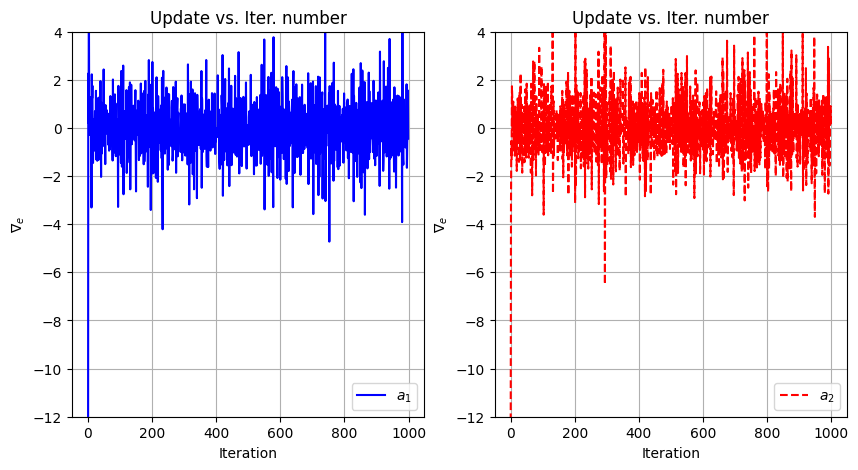

In [347]:
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
ax1.plot(np.arange(0, inc), update_hist[0,0:inc], 'b', label='$a_1$')
ax1.set_ylim([-12, 4])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('$\\nabla_e$')
ax1.set_title('Update vs. Iter. number')
ax1.legend()
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(0, inc), update_hist[1,0:inc], 'r--', label='$a_2$')
ax2.set_ylim([-12, 4])
ax2.set_xlabel('Iteration')
ax2.set_ylabel('$\\nabla_e$')
ax2.set_title('Update vs. Iter. number')
ax2.legend()
ax2.grid()

plt.show()

In [348]:
var1 = np.var(update_hist[0,:])
var2 = np.var(update_hist[1,:])

print('var do update de a1:', var1)
print('var do update de a2:', var2)

var do update de a1: 2.0221585631861347
var do update de a2: 1.7522244709320771


#### Observações

+ Como os atributos têm intervalos de variação semelhantes, o erro e, consequentemente, o gradiente, variam de forma semelhante em ambas as direções.


+ Variâncias estão dentro da mesma ordem de grandeza.

**Conclusões**

+ Os valores das variâncias mostram que o gradiente varia similarmente em ambas as direções (i.e., superfície circular).
    + Lembrem-se que o gradiente é uma medida da taxa de variação da função de erro em todas as direções.
+ As atualizações são ruidosas e, portanto, nem sempre o algoritmo segue na direção de máxima declividade da função.
+ Entretanto, o algoritmo se aproxima rapidamente da região onde se encontra o mínimo global.
+ Por a superfíce de erro ser circular, o GD em mini-batch não oscila ao longo das encostas da superfície, fazendo um progresso rápido em direção à região do mínimo global.

+ **O vetor gradiente aponta na direção do ponto de mínimo!**
  + A **decomposição do vetor gradiente** mostra que o erro varia similarmente em ambas as direções.

<img src="https://github.com/zz4fap/tp555-ml/blob/main/figures/superficie_circular.png?raw=1" width="300px">

**E se a superfície tiver um formato de ravina, para onde aponta o vetor gradiente?**

### Superfície de erro elíptica.

O intervalo de variação dos atributos é diferente. No exemplo abaixo, o atributo $x_1$ tem um desvio padrão 10 vezes maior do que o do atributo $x_2$.

In [349]:
# Always reset the pseudo random number generator to the same number.
np.random.seed(seed)
random.seed(seed)

In [350]:
# Define the number of examples.
N = 100

# Features.
x1 = np.sqrt(100)*np.random.randn(N, 1)
x2 = np.random.randn(N, 1)

# Noise.
w = np.random.randn(N, 1)

# Generate target function.
y = 4 * x1 + 4 * x2

# Observable model.
y_noisy = y + w

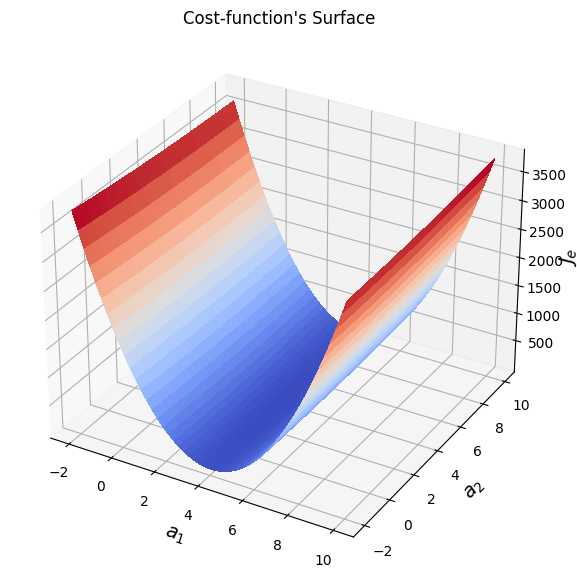

In [351]:
# Calculate the error surface.
A1, A2, J = errorSurface(x1, x2, y_noisy)

# Plot cost-function surface.
fig = plt.figure(figsize=(7,7))
plt.subplot(projection='3d')
ax = fig.gca()
surf = ax.plot_surface(A1, A2, J, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('$a_1$', fontsize=14)
ax.set_ylabel('$a_2$', fontsize=14)
ax.set_zlabel('$J_e$', fontsize=14)
ax.zaxis.labelpad=1
plt.title('Cost-function\'s Surface')
#Show the plot.
plt.show()

### Encontrando a solução ótima.

In [352]:
# Concatenate both column vectors, x1 and x2.
X = np.c_[x1, x2]

# Calculate optimum weights.
Joptimum, a_opt = normalEquation(X, y_noisy)

# Print a1 and a2 weights.
print('peso a1:', a_opt[0, 0])
print('peso a2:', a_opt[1, 0])
# Optimum MSE.
print('Joptimum:', Joptimum)

peso a1: 4.006345483980835
peso a2: 4.0395745783609165
Joptimum: 0.9034158375788078


### Econtrando a solução com GD em mini-batch.

**OBS**.: O valor do passo de aprendizagem abaixo é o maior valor possível, valores maiores do que este fazem com que o algoritmo divirja.

In [353]:
# Number of epochs.
n_epochs = 50

# Learning rate.
alpha_mbgd = 0.01 #(valor grande, mas que o termo momento fará estabilizar)

# Mini-batch size
mb_size = 5

# Mini-batch GD.
a_mbgd, Jgd_mbgd, a_hist, update_hist, alpha_hist, inc = mbgd(X, y_noisy, n_epochs, 'none', alpha_mbgd, 0.01, 0.0, mb_size)

# Print a1 and a2 weights.
print('peso a1:', a_mbgd[0, 0])
print('peso a2:', a_mbgd[1, 0])

peso a1: 4.023231584252257
peso a2: 4.524606812027706


### Superfície de contorno com histórico de atualização dos pesos.

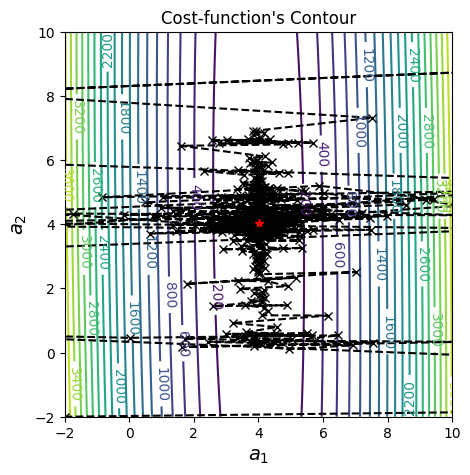

In [354]:
# Plot figure.
fig = plt.figure(figsize=(5,5))
cp = plt.contour(A1, A2, J, levels=20)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s Contour')
plt.plot(a_hist[0, 0:inc+1], a_hist[1, 0:inc+1], 'kx--')
plt.plot(a_opt[0], a_opt[1], c='r', marker='*')
plt.xticks(np.arange(-2, 12, step=2.0))
plt.yticks(np.arange(-2, 12, step=2.0))
plt.xlim([-2, 10])
plt.show()

#### Observações

+ Como o vetor gradiente é praticamente paralelo ao eixo $a_1$ (maior taxa de decrescimento da função), o algoritmo oscila ao longo das encostas da ravina.


+ O gradiente muda de direção em praticamente todas as iterações.

### Variação dos vetores gradiente e update.

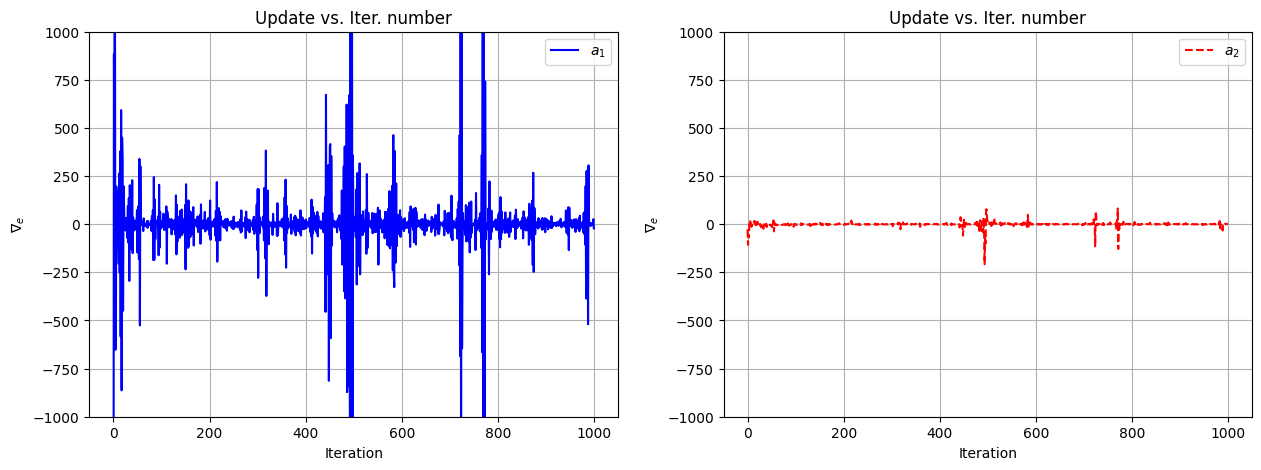

In [355]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.plot(np.arange(0, inc), update_hist[0,0:inc], 'b', label='$a_1$')
ax1.set_ylim([-1000, 1000])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('$\\nabla_e$')
ax1.set_title('Update vs. Iter. number')
ax1.legend()
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(0, inc), update_hist[1,0:inc], 'r--', label='$a_2$')
ax2.set_ylim([-1000, 1000])
ax2.set_xlabel('Iteration')
ax2.set_ylabel('$\\nabla_e$')
ax2.set_title('Update vs. Iter. number')
ax2.legend()
ax2.grid()

plt.show()

In [356]:
var1 = np.var(update_hist[0,:])
var2 = np.var(update_hist[1,:])

print('var do update de a1:', var1)
print('var do update de a2:', var2)
print('var(a2)/var(a1):', var1/var2)

var do update de a1: 102313.31066075024
var do update de a2: 172.37011169763497
var(a2)/var(a1): 593.5675834579972


#### Observações

+ Como $x_1$ tem um intervalo de variação muito maior do que $x_2$, o erro na direção de $a_1$ e, consequentemente, seu gradiente, variam muito mais do que os de $a_2$.


+ As variâncias **não** estão dentro da mesma ordem de grandeza. A variância da derivada parcial do erro em relação a $a_1$ é muito maior do que a em relação a $a_2$, indicando a grande diferença de inclinação entre as duas direções (i.e., pesos).

**Conclusões**

+ Os valores das variâncias mostram que o gradiente não varia igualmente em ambas as direções.
+ A variância da derivada parcial em relação ao peso $a_1$ (primeiro elemento do vetor gradiente) é muito maior do que a do peso $a_2$, indicando que a superfície tem uma inclinação muito grande naquele sentido.
+ Por a superfíce de erro ser elíptica, o GD em mini-batch oscila caóticamente ao longo das encostas da ravina, fazendo um **progresso vagaroso** em direção à região do mínimo global.
+ O ruído presente nas aproximações do vetor gradiente só faz piorar esse movimento de zig-zag.
+ Mesmo com um valor grande para o passo de aprendizagem, o algoritmo se aproxima muito lentamente da região onde se encontra o ponto de mínimo global.

+ **O vetor gradiente não aponta para o ponto de mínimo e sim para o outro lado da ravida.**
    + A **decomposição do vetor gradiente** mostra que o erro não varia de forma similar em ambas as direções.

<img src="https://github.com/zz4fap/tp555-ml/blob/main/figures/superficie_eliptica.png?raw=1" width="300px">

### Como poderíamos mitigar o problema da oscilação?

Adicionando um termo à atualização dos pesos que é a **média móvel de valores anteriores do gradiente**, de tal forma que as oscilações sejam suavizadas e a velocidade de convergência aumentada.

<img src="https://github.com/zz4fap/tp555-ml/blob/main/figures/adi%C3%A7%C3%A3o_do_termo_momentum.png?raw=1" width="500px">

**Neste exemplo, veremos o caso em que o termo momento suaviza as oscilações e melhora a convergência do algoritmo.**

### Superfície elíptica com termo momentum.

In [357]:
# Always reset the pseudo random number generator to the same number.
np.random.seed(seed)
random.seed(seed)

In [358]:
# Define the number of examples.
N = 100

# Features.
x1 = np.sqrt(100)*np.random.randn(N, 1)
x2 = np.random.randn(N, 1)

# Noise.
w = np.random.randn(N, 1)

# Generate target function.
y = 4 * x1 + 4 * x2

# Observable model.
y_noisy = y + w

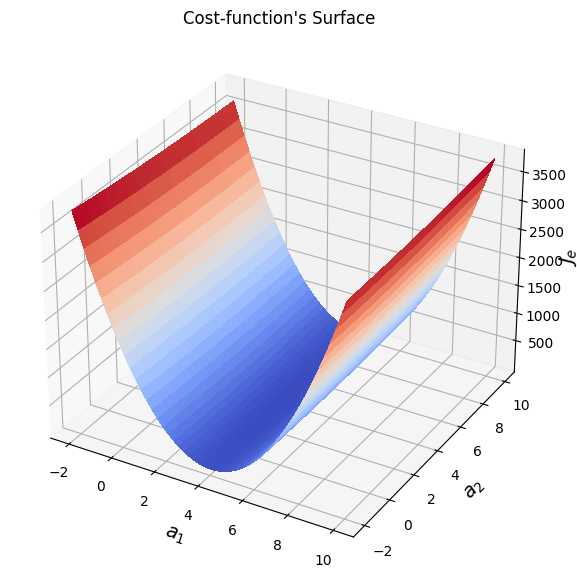

In [359]:
# Calculate the error surface.
A1, A2, J = errorSurface(x1, x2, y_noisy)

# Plot cost-function surface.
fig = plt.figure(figsize=(7,7))
plt.subplot(projection='3d')
ax = fig.gca()
surf = ax.plot_surface(A1, A2, J, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('$a_1$', fontsize=14)
ax.set_ylabel('$a_2$', fontsize=14)
ax.set_zlabel('$J_e$', fontsize=14)
ax.zaxis.labelpad=1
plt.title('Cost-function\'s Surface')
#Show the plot.
plt.show()

In [360]:
# Concatenate both column vectors, x1 and x2.
X = np.c_[x1, x2]

# Calculate optimum weights.
Joptimum, a_opt = normalEquation(X, y_noisy)

# Print a1 and a2 weights.
print('peso a1:', a_opt[0, 0])
print('peso a2:', a_opt[1, 0])
# Optimum MSE.
print('Joptimum:', Joptimum)

peso a1: 4.006345483980835
peso a2: 4.0395745783609165
Joptimum: 0.9034158375788078


### Adicionando o termo momentum.

+ O coeficiente de momentum, $\mu$, controla a quantidade de histórico (momentum) a ser incluído na equação de atualização dos pesos.

+ Um grande coeficiente de momentum, por exemplo, 0.9, significará que a atualização será fortemente influenciada por uma grande quantidade de valores anteriores, enquanto um coeficiente de momentum pequeno, por exemplo 0.1, significará uma influência muito pequena do histórico.

In [361]:
# Number of epochs.
n_epochs = 50

# Constant learning rate.
alpha_mom = 0.01

# Coefficient of momentum.
mu = 0.75

# Mini batch size
mb_size = 5

# Mini-batch GD with momentum term.
a_mom, Jgd_mom, a_hist, update_hist, alpha_hist, inc = mbgd(X, y_noisy, n_epochs, 'mom', alpha_mom, 0.01, mu, mb_size)

# Print a1 and a2 weights.
print('peso a1:', a_mom[0, 0])
print('peso a2:', a_mom[1, 0])

peso a1: 3.980969967505558
peso a2: 4.05263056115334


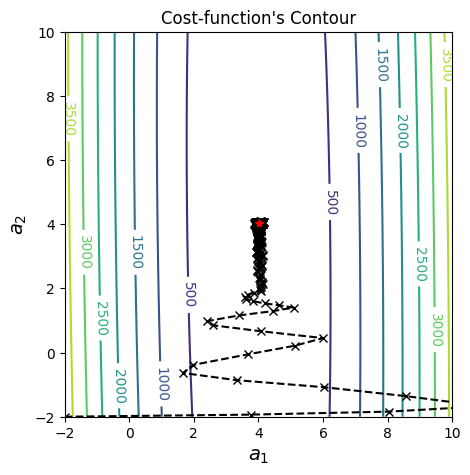

In [362]:
# Plot figure.
fig = plt.figure(figsize=(5,5))
cp = plt.contour(A1, A2, J)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s Contour')
plt.plot(a_hist[0, :], a_hist[1, :], 'kx--')
plt.plot(a_opt[0], a_opt[1], c='r', marker='*')
plt.xticks(np.arange(-2, 12, step=2.0))
plt.yticks(np.arange(-2, 12, step=2.0))
plt.xlim([-2, 10])
plt.ylim([-2, 10])
plt.show()

#### Observações

+ Quando a aproximação do vetor gradiente muda diversas vezes de direção, o termo momentum suaviza essas mudanças.


+ Quando a aproximação do vetor gradiente aponta na mesma direção por diversas iterações, o termo acelera a convergência.


+ O termo momentum suavizou as oscilações e o algoritmo praticamente convergiu para o ponto de mínimo


+ A oscilação é pequena ao redor do mínimo.




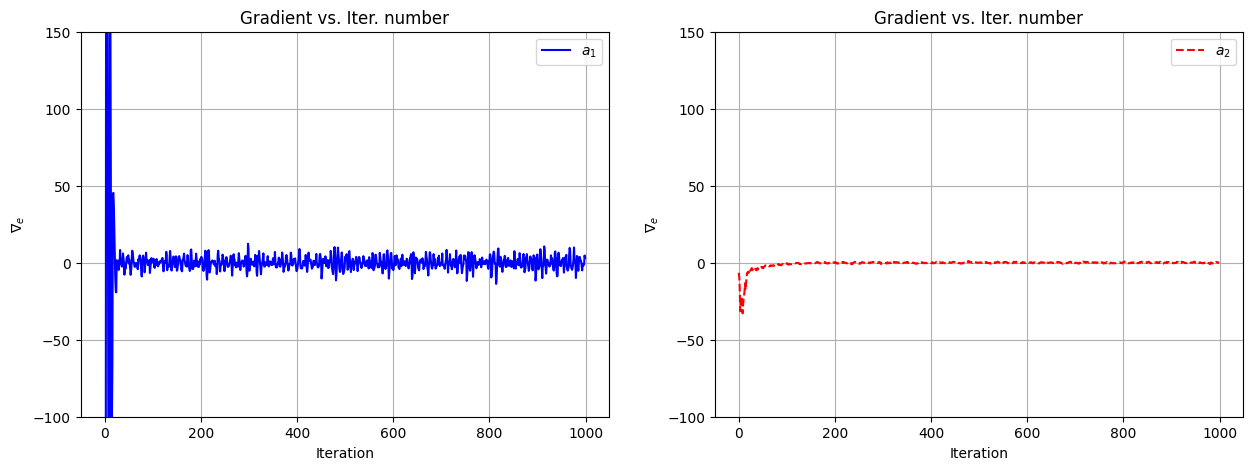

In [363]:
fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.plot(np.arange(0, inc), update_hist[0,0:inc], 'b', label='$a_1$')
ax1.set_ylim([-100, 150])
ax1.set_xlabel('Iteration')
ax1.set_ylabel('$\\nabla_e$')
ax1.set_title('Gradient vs. Iter. number')
ax1.legend()
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(0,inc), update_hist[1,0:inc], 'r--', label='$a_2$')
ax2.set_ylim([-100, 150])
ax2.set_xlabel('Iteration')
ax2.set_ylabel('$\\nabla_e$')
ax2.set_title('Gradient vs. Iter. number')
ax2.legend()
ax2.grid()

plt.show()

+ O termo momentum tem como objetivo principal suavizar as oscilações de versões usando a aproximação estocástica do vetor gradiente e, com isso, melhorar a convergência.

In [364]:
var1 = np.var(update_hist[0,:])
var2 = np.var(update_hist[1,:])

print('var a1:', var1)
print('var a2:', var2)
print('var(a2)/var(a1):', var1/var2)

var a1: 988.1936923157208
var a2: 8.33405883908555
var(a2)/var(a1): 118.57292003762116


### Comparando versões com e sem o termo momentum.

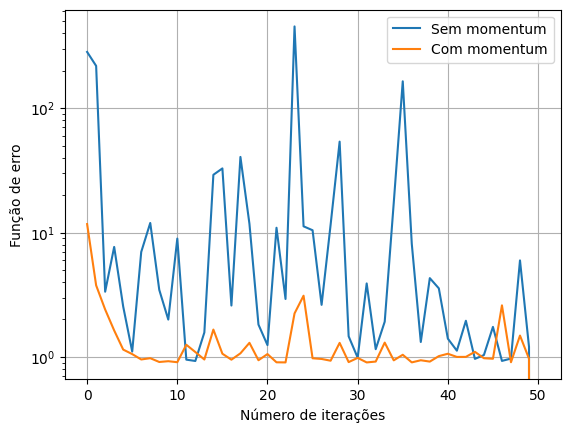

In [365]:
# Plotando a curva de aprendizado
plt.plot(Jgd_mbgd, label='Sem momentum')
plt.plot(Jgd_mom, label='Com momentum')
plt.xlabel('Número de iterações')
plt.ylabel('Função de erro')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()